# Can twitter tell me which neighborhood to live in?

200,000 geotagged tweets from NYC have been assigned to Neighborhood Tabulation Areas from NYC Open Data.  The ten neighborhoods with the most tweets are analyzed to see which neighborhoods have the most mentions of certain real estate key words.

##### Import a bunch of stuff

In [32]:
# Import module to handle regular expressions
import re

# Import pandas and numpy to handle data
import pandas as pd
import numpy as np

# Import libraries for accessing the database
import psycopg2
from sqlalchemy import create_engine
from postgres_credentials import *

# Import libraries for visualization
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Import nltk to check english lexicon
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn

# Import libraries for accessing the database
import psycopg2
from psycopg2 import sql
from sqlalchemy import create_engine
from postgres_credentials import *


##### Create functions for the project

###### Functions to query the PostgreSQL databases

In [2]:
# Query the NYC tweet database for all tweets from a neighborhood
def query_database(nb):
	engine = create_engine("postgresql+psycopg2://%s:%s@%s:%s/%s" %(usertwitter, passwordtwitter, hosttwitter, porttwitter, dbnametwitter))
	table = pd.read_sql_query("""SELECT tweet FROM NYC_tweets WHERE neighborhood = '%s';""" %(nb,),con=engine)
	return table

###### Functions to pre-process the tweets

In [40]:
# Preprocess text in tweets by removing links, @UserNames, blank spaces, etc.
def preprocessing_text(table):
# Put everything in lowercase
	table['tweet'] = table['tweet'].str.lower()
# Replace occurences of mentioning @UserNames
	table['tweet'] = table['tweet'].replace(r'@\w+', '', regex=True)
# Replace links contained in the tweet
	table['tweet'] = table['tweet'].replace(r'http\S+', '', regex=True)
	table['tweet'] = table['tweet'].replace(r'www.[^ ]+', '', regex=True)
# Replace special characters and puntuation marks
	table['tweet'] = table['tweet'].replace(r'[!"#$%&()*+,-./:;<=>?@[\]^_`{|}~]', '', regex=True)
	return table

# Remove stop words, including NYC specific stopwords
def stop_words(table):
	stop_words_list = stopwords.words('english')
	stop_words_list_nyc = ["follow us","n't","want work","getrepost","re","latest","hiring","looking","amp","newyorkcity","posted","post","click","photo","repost","click","link","click link","newyork","new york","new york city","city","ny","nyc","new","york","job","bio","apply"]
	stop_words_list = stop_words_list + stop_words_list_nyc
	table['tweet'] = table['tweet'].str.lower()
	table['tweet'] = table['tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words_list)]))
	return table

# Run the above cleaning functions for the text in the tweets
def cleaning_table(table):
	table = preprocessing_text(table)
	table = stop_words(table)
	return table

###### Function to create a list of real-estate relevant search words using NLTK wordnet

In [4]:
# Make a list of all searchwords - including synonyms, hypernyms, hyponyms, meronyms, holonyms, and entailments
def all_word_search_list(word):
	list=[]
	syn=wn.synset(word)
	for l in syn.lemma_names(): 
		list.append(l)
	for hyper in syn.hypernyms():
		for l in hyper.lemma_names():
			list.append(l)
	for hypo in syn.hyponyms():
		for l in hypo.lemma_names():
			list.append(l)
	for m in syn.part_meronyms():
		for l in m.lemma_names():
			list.append(l)
	for h in syn.part_holonyms():
		for l in h.lemma_names():
			list.append(l)
	for e in syn.entailments():
		for l in e.lemma_names():
			list.append(l)
	return(list)

###### Functions to plot results

In [5]:
# Make a wordcloud from words in the tweets from the top 10 neighborhoods
def word_cloud(tweet_table,nb,i):
# Create series of tweets
	tweets_list = pd.Series([t for t in tweet_table.tweet]).str.cat(sep=' ')  
	wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(tweets_list)
# Plot the wordcloud
	plt.subplot(3,4,i+1) 
	plt.imshow(wordcloud, interpolation="bilinear") 
	plt.axis("off") 
	plt.title(nb)

In [6]:
# Make a bar graph of the word frequencies from the real estate words list
def bar_graph(nb,word_freq,i):
	plt.subplot(10,1,i+1)
	title = nb
# Plot the figures
	plt.bar(np.arange(16), word_freq)# width = 0.8, alpha=0.5, capsize=8, linewidth=1);
	axes = plt.gca()
	axes.set_ylim([0,.2])
	plt.title(title)
	plt.grid(False);
	plt.xticks(np.arange(16), [], rotation=90);
	if i+1 == 5:
		plt.ylabel("Frequency in count/tweets");
	if i+1 == 10:
		labels = freq_cat
		plt.xticks(np.arange(16), labels, rotation=90);
		plt.xlabel("Word");

##### The Main Function 

In [14]:
# Connect to the Twitter Database created in Postgres
conn = psycopg2.connect(dbname=dbnametwitter, user=usertwitter, password=passwordtwitter, host=hosttwitter, port=porttwitter)
# Create a cursor to perform database operations
cursor = conn.cursor()

In [48]:
# Get the 10 neighborhoods with the most tweets
cursor.execute("SELECT neighborhood_name FROM Neighborhood_tweets ORDER BY tweet_count DESC LIMIT 10;")
neighborhoods = [r[0] for r in cursor.fetchall()]

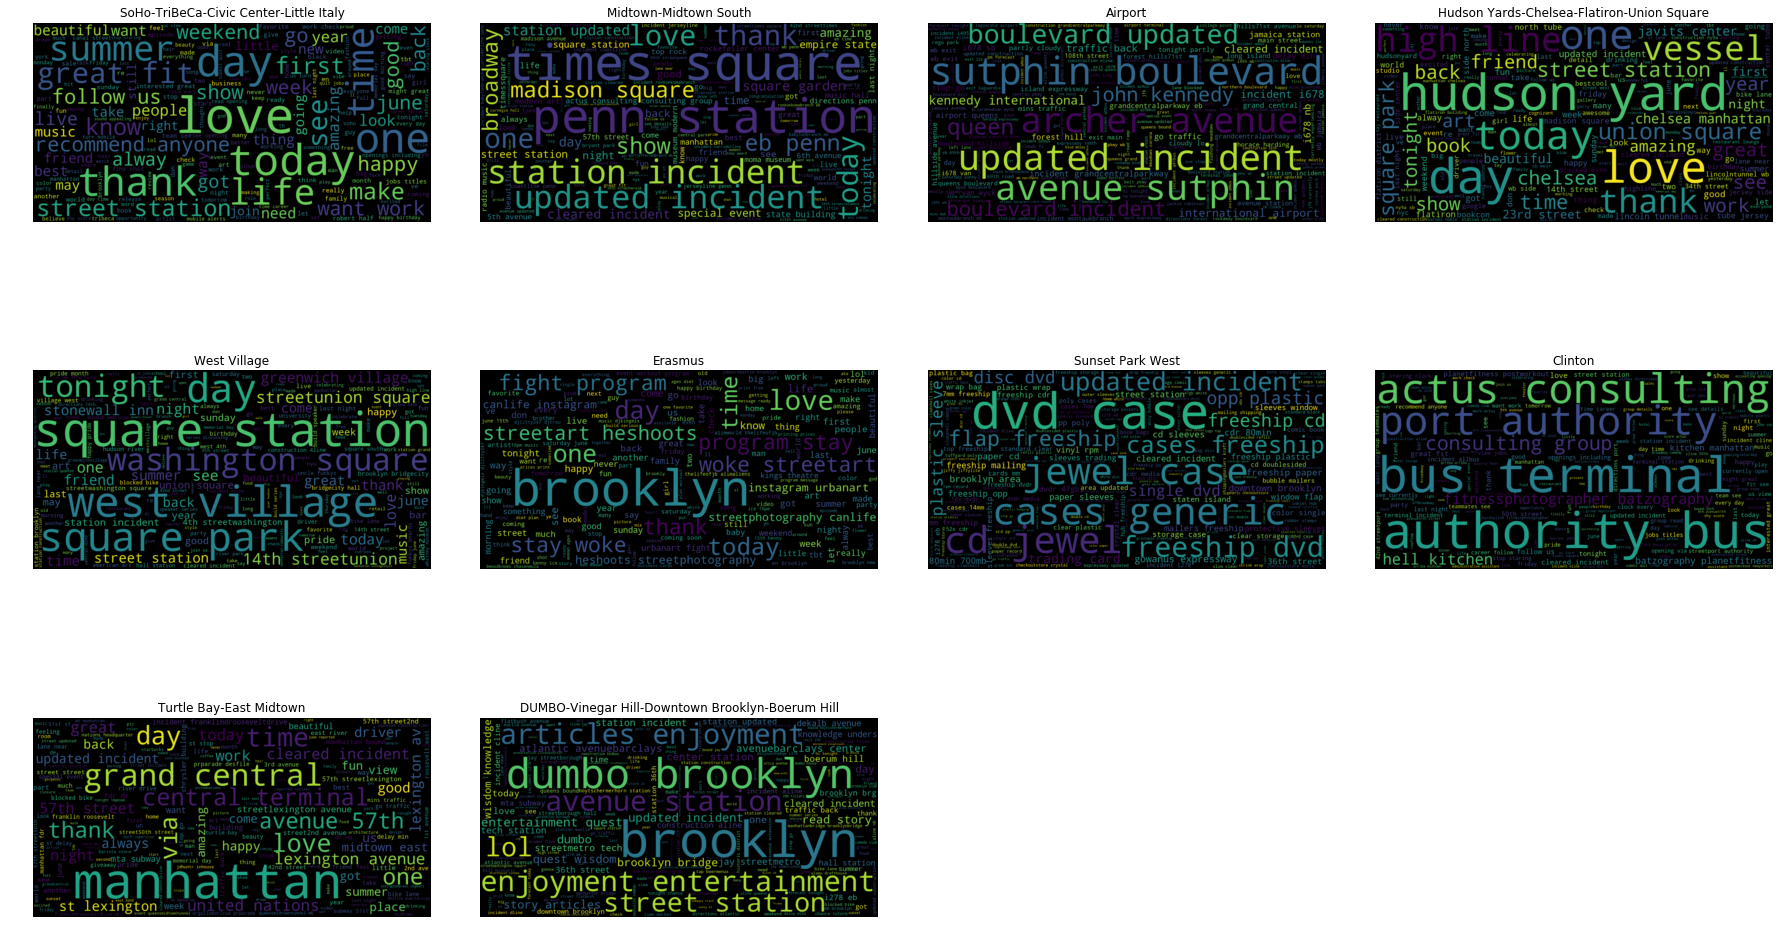

In [42]:
# Create a word cloud for each of the top 10 neighborhoods
# Open a figure 
plt.figure(1,figsize=(25,15))

for nb in enumerate(neighborhoods):
	tweet_table=query_database(nb[1])
	tweet_table['tweet'] = tweet_table['tweet'].str.lower()
	tweet_table = cleaning_table(tweet_table)
	word_cloud(tweet_table,nb[1],nb[0])

plt.tight_layout()
plt.savefig("Neighborhood_Word_Cloud.png", format="png")
plt.show() 

In [10]:
# Create the neighborhood frequency table to count tweets in each neighborhood, first make sure to delete the old table
cursor.execute("DROP TABLE IF EXISTS Neighborhood_frequencies;")
conn.commit()
cursor.execute("CREATE TABLE IF NOT EXISTS Neighborhood_frequencies (neighborhood_id SERIAL, neighborhood_name text,  tweet_count int, museum_freq float, shopping_freq float, subway_freq float, theater_freq float, park_freq float, music_freq float, library_freq float, restaurant_freq float, crime_freq float, family_freq float, traffic_freq float, beautiful_freq float, quiet_freq float, bar_freq float, old_freq float, construction_freq float);")
conn.commit()

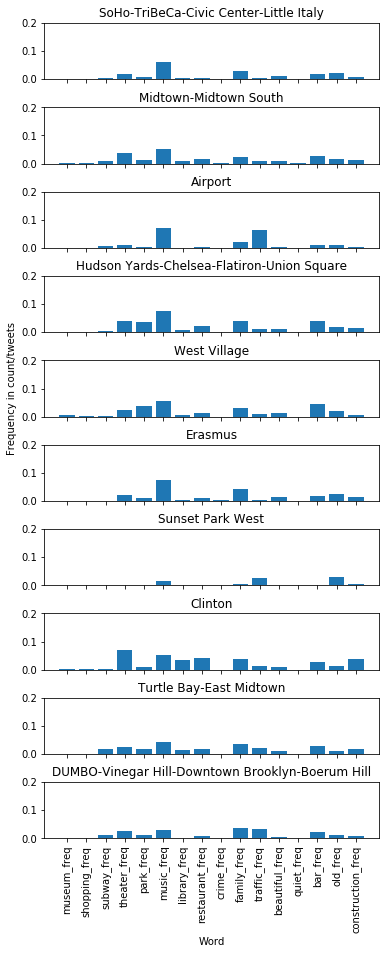

<Figure size 432x288 with 0 Axes>

In [15]:
# Make lists of real estate synsets and words
words = ['museum.n.01','shopping.n.01','metro.n.01','theater.n.01','park.n.02','music.n.01','library.n.05','restaurant.n.01','crime.n.01','family.n.01','traffic.n.01','beautiful.a.01','quiet.a.01','barroom.n.01','old.a.02','construction.n.07']
freq_cat = ['museum_freq', 'shopping_freq', 'subway_freq', 'theater_freq', 'park_freq' , 'music_freq', 'library_freq', 'restaurant_freq', 'crime_freq', 'family_freq', 'traffic_freq', 'beautiful_freq', 'quiet_freq', 'bar_freq', 'old_freq', 'construction_freq']

# Open a figure 
plt.figure(1,figsize=(6,15))

# Iterate through the 10 neighborhoods and add word frequencies to the neighborhood frequency table
for nb in enumerate(neighborhoods):
    
# Check how many tweets come from the neighborhood
	if nb[1] is not None:
		cursor.execute("SELECT COUNT(id) FROM NYC_tweets WHERE neighborhood=%s;",(nb[1],))
		nb_count=cursor.fetchone()[0]

# Update the neighborhood table with the neighborhood name and tweet count
		cursor.execute("INSERT INTO Neighborhood_frequencies (neighborhood_name, tweet_count) VALUES (%s, %s);", (nb[1], nb_count))
		conn.commit()

# Make a word frequency list to use for the bar graph
		word_freq=[]

# Get word frequencies and put them into SQL table and word frequency list
		tweet_table = query_database(nb[1])
		for element in enumerate(words):
			word_list = all_word_search_list(element[1])
			w_sum  = 0
			for word in word_list:
				w_sum = w_sum + tweet_table.tweet.str.count(word).sum()
			fcat = freq_cat[element[0]]
			cursor.execute(sql.SQL("UPDATE Neighborhood_frequencies SET {} = %s WHERE neighborhood_name = %s").format(sql.Identifier(fcat)),[w_sum/nb_count,nb[1]])
			conn.commit()
			word_freq.append(w_sum/nb_count)

# Plot the bar graph
		bar_graph(nb[1],word_freq,nb[0])

plt.subplots_adjust(hspace=0.5)
plt.show()
plt.savefig("Neighborhood_Word_Count_bar.png",format="png")

In [12]:
# Finish up by closing the cursor and the connection
cursor.close()
conn.close()